# Hybrid (first->second order) optimization for PINNs

In this notebook we study **optimization strategies for Physics-Informed Neural Networks (PINNs)**,
focusing on a one-dimensional Poisson problem.

We compare:
- Adam,
- L-BFGS,
- a hybrid Adam → L-BFGS strategy with automatic switching.

Adam is an adaptive first-order optimization that maintains per-parameter adaptive learning rates via momentum and second moments. It is inherently robust to poor scaling and initialization and is thus excellent in early training when gradients may be unreliable. It may stagnate near convergence.

L-BFGS is a quasi-Newton method that
builds a low-rank approximation of the inverse Hessian from curvature history. It
achieves superlinear convergence near a minimizer and is thus
very effective for final accuracy improvements. It is better suited to the second stage of the optimization, since it requires good initialization since poor starting points can lead to failures.


The key insight of the hybrid strategy is to combine the complementary strengths of the two methods:
- **Adam phase** (exploration): robust initialization and coarse convergence to a good region
- **L-BFGS phase** (refinement): fast superlinear convergence to high accuracy



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

## 2. Model problem: 1D Poisson equation

We consider the Poisson problem on $\Omega = (0,1)$:
$$-u''(x) = f(x), \qquad u(0)=u(1)=0,$$
with a forcing term containing multiple frequencies.

In [2]:
def u_exact_np(x):
    """Exact solution: superposition of three sine modes."""
    return (
        np.sin(np.pi * x)
        + 0.3 * np.sin(4 * np.pi * x)
        + 0.1 * np.sin(9 * np.pi * x)
    )

def f_force(x):
    """Forcing term: RHS of -u''(x) = f(x)."""
    return (
        -(np.pi**2) * torch.sin(np.pi * x)
        - 0.3 * (4*np.pi)**2 * torch.sin(4*np.pi * x)

        - 0.1 * (9*np.pi)**2 * torch.sin(9*np.pi * x)    )

## 3. PINN with embedded boundary conditions and collocation points

We parameterize the solution as:
$$u_\theta(x) = (1-x)u(0) + x u(1) + x(1-x)\,h_\theta(x),$$
where $h_\theta(x)$ is a neural network. In this way we enforce boundary conditions by embedding them into the network
architecture. This approach guarantees that BC are exactly satisfied and
eliminates the weight hyperparameters that require tuning.

We sample the collocation points uniformly in $[0,1]$.

In [3]:
# Extract boundary values
u0 = float(u_exact_np(0.0))
u1 = float(u_exact_np(1.0))

# Training mesh
Ntrain = 300
x_np = np.linspace(0.0, 1.0, Ntrain)
x = torch.tensor(x_np, dtype=torch.float32).unsqueeze(1)


# Reference solution and forcing function f_rhs = f_force(x)
u_exact = torch.tensor(u_exact_np(x_np), dtype=torch.float32).unsqueeze(1)
f_rhs = f_force(x)

class PINN(nn.Module):
    def __init__(self, width=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, width), nn.Tanh(),
            nn.Linear(width, width), nn.Tanh(),
            nn.Linear(width, 1)
        )

    def forward(self, x):
        n = self.net(x)
        # boundary embeddings
        return (1 - x) * u0 + x * u1 + x*(1-x) * n



## 4. Computing the PDE residual

The Poisson equation involves second order derivatives, which we compute
using automatic differentiation, and which will be used to copute the PINN loss.

In [4]:
def pinn_second_derivative(model, x):
    """Compute d²u/dx² via automatic differentiation (2nd order)."""
    xg = x.clone().detach().requires_grad_(True)
    u = model(xg)
    # First derivative
    du = torch.autograd.grad(u, xg, torch.ones_like(u), create_graph=True)[0]
    # Second derivative
    d2u = torch.autograd.grad(du, xg, torch.ones_like(du), create_graph=True)[0]

    return d2u

loss_fn = nn.MSELoss()



## 5. Utility functions

We use helper routines to clone identical initializations and to evaluate the PDE loss and the solution error.

In [5]:
def clone_params_from(model_source, model_target):
    with torch.no_grad():
        for p_src, p_tgt in zip(model_source.parameters(), model_target.parameters()):
            p_tgt.copy_(p_src)

def compute_loss_and_error(model, x, f_rhs, u_exact):
    """Compute PDE residual and solution error."""
    uxx = pinn_second_derivative(model, x)
    loss = loss_fn(uxx, f_rhs).item()
    err = torch.norm(model(x) - u_exact).item()
    return loss, err

## 6. Optimizers:  Adam and L-BFGS

We use PyTorch's optimizers. PyTorch's L-BFGS requires a *closure* because it may evaluate
the loss and gradient multiple times per step.



In [6]:
def train_adam(model, x, f_rhs, u_exact, iters=2000, lr=1e-3):
    """Train PINN with Adam optimizer."""
    opt = optim.Adam(model.parameters(), lr=lr)
    losses, errs = [], []

    for k in range(iters):
        opt.zero_grad()
        uxx = pinn_second_derivative(model, x)
        loss = loss_fn(uxx, f_rhs)  # Minimize PDE residual
        loss.backward()
        opt.step()

        L, E = compute_loss_and_error(model, x, f_rhs, u_exact)
        losses.append(L)
        errs.append(E)

        if k % 200 == 0:
            print(f"[Adam] iter {k:4d} | loss={L:.3e} | err={E:.3e}")

    return np.array(losses), np.array(errs)

In [7]:
def train_lbfgs(model, x, f_rhs, u_exact,
                max_iters=500,
                history_size=50,
                tol_grad=1e-12,
                tol_change=1e-12):
    """Train PINN with L-BFGS optimizer (quasi-Newton method)."""
    losses, errs = [], []

    opt = optim.LBFGS(
        model.parameters(),
        max_iter=1,
        history_size=history_size,
        line_search_fn="strong_wolfe",
        tolerance_grad=tol_grad,
        tolerance_change=tol_change
    )

    for k in range(max_iters):
        # L-BFGS requires a closure for re-evaluation
        def closure():
            opt.zero_grad()
            uxx = pinn_second_derivative(model, x)
            loss = loss_fn(uxx, f_rhs)
            loss.backward()
            return loss

        opt.step(closure)

        L, E = compute_loss_and_error(model, x, f_rhs, u_exact)
        losses.append(L)
        errs.append(E)

        if k % 50 == 0:
            print(f"[LBFGS] iter {k:4d} | loss={L:.3e} | err={E:.3e}")

    return np.array(losses), np.array(errs)

## 7. Automatic Adam → L-BFGS switching

The key point to combine Adam and L-BFGS is to understand when to switch from one to the other. In this experiment we monitor the gradient norm $\|\nabla f\|_2$ during Adam training.
When its decrease stagnates over a sliding window, we switch automatically to L-BFGS.

More precisely, we compare the mean gradient norm over recent iterations versus earlier iterations.
If the ratio exceeds a threshold (here 0.995), convergence has plateaued and it's time to switch.

This provides a principled, data-driven transition criterion that requires no manual tuning
of iteration counts or wall-clock time.

In [8]:
def train_adam_then_lbfgs_automatic_switch(
        model,
        x, f_rhs, u_exact,
        adam_max_iters=8000,
        adam_min_iters=500,
        lbfgs_iters=1000,
        lr_adam=1e-4,
        window=200,
        plateau_tol=0.995,
        history_size=50,
        tol_grad=1e-12,
        tol_change=1e-12):
    """Train with Adam first, then automatically switch to L-BFGS on convergence plateau."""
    losses, errs, grad_norms = [], [], []

    opt_adam = optim.Adam(model.parameters(), lr=lr_adam)

    def grad_norm():
        """Compute L2 norm of gradients."""
        return sum(p.grad.norm().item()**2 for p in model.parameters()
                   if p.grad is not None)**0.5

    # ----- Adam stage: early exploration -----
    for k in range(adam_max_iters):
        opt_adam.zero_grad()
        uxx = pinn_second_derivative(model, x)
        loss = loss_fn(uxx, f_rhs)
        loss.backward()
        opt_adam.step()

        L, E = compute_loss_and_error(model, x, f_rhs, u_exact)
        gnorm = grad_norm()

        losses.append(L)
        errs.append(E)
        grad_norms.append(gnorm)

        # Check for convergence plateau using sliding window
        if k > adam_min_iters + window:
            r = np.mean(grad_norms[-window:]) / np.mean(grad_norms[-2*window:-window])
            if r > plateau_tol:  # Stagnation detected
                print(f">>> Switching to L-BFGS at iter {k}")
                break

    # ----- L-BFGS stage: final refinement -----
    opt_lbfgs = optim.LBFGS(
        model.parameters(),
        max_iter=1,
        history_size=history_size,
        line_search_fn="strong_wolfe",
        tolerance_grad=tol_grad,
        tolerance_change=tol_change
    )

    for k in range(lbfgs_iters):
        def closure():
            opt_lbfgs.zero_grad()
            uxx = pinn_second_derivative(model, x)
            loss = loss_fn(uxx, f_rhs)
            loss.backward()
            return loss

        opt_lbfgs.step(closure)

        L, E = compute_loss_and_error(model, x, f_rhs, u_exact)
        losses.append(L)
        errs.append(E)

    return np.array(losses), np.array(errs), np.array(grad_norms)

## 8. Comparison

We compare the three optimizers starting from the same initial guess.

In [9]:
# Initialize three identical PINNs
model_adam = PINN()
model_lbfgs = PINN()
model_hybrid = PINN()

# Clone parameters for fair comparison
clone_params_from(model_adam, model_lbfgs)
clone_params_from(model_adam, model_hybrid)

# Train each model with different strategies
loss_adam, err_adam = train_adam(model_adam, x, f_rhs, u_exact, iters=5000, lr=5e-4)
loss_lbfgs, err_lbfgs = train_lbfgs(model_lbfgs, x, f_rhs, u_exact, max_iters=5000)
loss_hybrid, err_hybrid, _ = train_adam_then_lbfgs_automatic_switch(model_hybrid,
                                                                    x, f_rhs, u_exact,
                                                                    adam_max_iters=8000,
                                                                    adam_min_iters=500,
                                                                    lbfgs_iters=1500,
                                                                    lr_adam=5e-4,)

[Adam] iter    0 | loss=4.354e+03 | err=1.253e+01
[Adam] iter  200 | loss=3.720e+03 | err=4.618e+00
[Adam] iter  400 | loss=4.408e+02 | err=3.344e+00
[Adam] iter  600 | loss=1.740e+01 | err=3.133e-01
[Adam] iter  800 | loss=4.236e+00 | err=3.295e-02
[Adam] iter 1000 | loss=2.733e+00 | err=7.923e-02
[Adam] iter 1200 | loss=2.168e+00 | err=9.183e-02
[Adam] iter 1400 | loss=1.825e+00 | err=9.359e-02
[Adam] iter 1600 | loss=1.572e+00 | err=9.257e-02
[Adam] iter 1800 | loss=1.387e+00 | err=9.047e-02
[Adam] iter 2000 | loss=1.254e+00 | err=8.970e-02
[Adam] iter 2200 | loss=1.166e+00 | err=9.220e-02
[Adam] iter 2400 | loss=1.112e+00 | err=9.421e-02
[Adam] iter 2600 | loss=1.073e+00 | err=9.396e-02
[Adam] iter 2800 | loss=1.037e+00 | err=9.195e-02
[Adam] iter 3000 | loss=1.011e+00 | err=8.884e-02
[Adam] iter 3200 | loss=9.676e-01 | err=8.577e-02
[Adam] iter 3400 | loss=9.301e-01 | err=8.289e-02
[Adam] iter 3600 | loss=1.154e+00 | err=5.521e-02
[Adam] iter 3800 | loss=5.130e-01 | err=2.565e-02


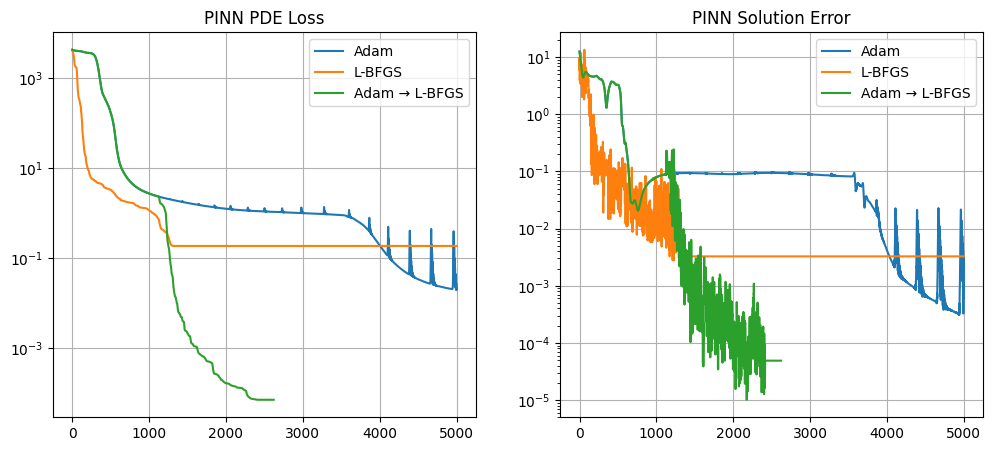

<Figure size 640x480 with 0 Axes>

In [10]:
# Compare convergence curves
plt.figure(figsize=(12,5))

# PDE residual loss
plt.subplot(1,2,1)
plt.semilogy(loss_adam, label="Adam")
plt.semilogy(loss_lbfgs, label="L-BFGS")
plt.semilogy(loss_hybrid, label="Adam → L-BFGS")
plt.title("PINN PDE Loss")
plt.legend(); plt.grid(True)

# Solution error
plt.subplot(1,2,2)
plt.semilogy(err_adam, label="Adam")
plt.semilogy(err_lbfgs, label="L-BFGS")
plt.semilogy(err_hybrid, label="Adam → L-BFGS")
plt.title("PINN Solution Error")
plt.legend(); plt.grid(True)

plt.show()
plt.tight_layout()

## 9. Discussion

We can see that the hybrid strategy outperforms both Adam and L-BFGS. Even if L-BFGS provides a quicker initial decrease, it later stagnates.
The inital phase with Adam avoids L-BFGS to get stack, by providing a better starting point.

The automatic switching strategy uses gradient norm stagnation as a signal, eliminating manual iteration count guessing. This approach scales well to high-dimensional PINNs and other PDE-constrained optimization problems.